# SCRIPT 2
Edit raw data and compute velocity components.

Steps:
1. ds_raw: Load an individual raw drifter dataset with GPS, temperature and other variables on non-uniform t.
    Create tgrid_hourly from the original time data.
2. ds_qc: Flag + remove bad GPS data
    - Where the GPS has dropped out (= mode),
    - Where it is outside the North Atlantic box (na_lonlim, na_latlim)
    - Where the velocity is unrealistic (larger than 3 m/s)
    - Where the time series of longitude and latitude (compared to a one-dimensional five-point median filter) is more than five standard deviations from the five-point median)
     Compute the u and v velocities on the QC GPS fixes
4. ds_lowess: Smooth the GPS (and velocities) using the Lowess filter*.  *Shane's code online doesn't seem to smooth velo with a Lowess
5. ds_hourly: Hourly interpolate the resultant ds_lowess back onto the tgrid_hourly.  Interpolate the other parameters from ds_raw onto the hourly grid (temperature, etc)
    > 'linear' for continuous variables
    > 'nearest neighbour' for discrete ones

6. save as netcdf file

Last modified: 5 Sep 2021

In [1]:
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
# Import modules

import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import datetime
import gsw
import os
import glob
import sys
import re
from scipy import stats
import time
from scipy.io import loadmat


%load_ext autoreload
%autoreload 2

# Local import
# > Make sure SIO_wrap dir is on the same path as this script.

from SIO_wrap import dir_tree, fnames
from SIO_wrap.lowess import LatLonLocalWess
from SIO_wrap import jlab_python as jlab
from SIO_wrap import drifter_qc as dqc

from setdir import *



/Users/eddifying/Python/drifters/ already exists
/Users/eddifying/Python/drifters/02-code/ already exists
/Users/eddifying/Python/drifters/02-code/SIO_wrap/ already exists
/Users/eddifying/Python/drifters/01-data/04-aux/ already exists
/Users/eddifying/Python/drifters/01-data/02-intermediate/ already exists


# User edits

In [6]:
# Path for the output data
data_dir = dir_tree.dir_out

#--------------
# Flag value - good=1, bad=4
good_flagval = 1
bad_gps_flagval = 4 
bad_vel_flagval = 3

# FLAG 1: Latitude values less than this threshold are flagged + removed?
#latbad_threshold = 0
# Use statistical mode instead

# FLAG 2: North Atlantic box; values outside this box are flagged + removed?
# Defined from -180 to 180 (lon) and -90 to 90 (lat)
na_lonlim = [-80, 30]
na_latlim = [40, 80]

#--------------
# Speed threshold; values outside [-3, 3] m/s are flagged + removed?
vel_threshold = 3 # in m/s

#--------------
# LOWESS params
poly_order = 1
bandwidth = 2

#------------
# Names of variables
latname = 'GPS_Latitude_deg'
lonname = 'GPS_Longitude_deg'
uvelname = 'uvel'
vvelname = 'vvel'

#--------------
# Time formats
tstamp_strftime = '%Y%m%d'  # Filename timestamp
timcol_strftime = '%Y-%m-%d %H:%M:%S'  # Convert text to datetime format 

# Reference date for computing time in seconds
# Can use an earlier time reference if data start before 2000
ref_time = datetime.datetime(2000, 1, 1)

#--------------
# List of variable names split between float/int types based on whether the 
# variables are continuous or discrete, respectively.
# <!> If the names of variables change, update the lists by printing a list of 
# all the names from the raw datafile: list(xarrayDataset.keys())

integ_vars = ['Drogue_cnts', 'GPS_HDOP', 'GPS_FixDelay', 'GPS_TTFF', 
              'GPS_NumSat', 'SBD_Transmit_Delay', 'SBD_Retries']

float_vars = [lonname, latname, 'SST_degC', 'time_seconds',
              'SLP_mB', 'Battery_volts', uvelname, vvelname]


In [16]:
# Process bathymetry data
matlab_file = 'labsea_66.44W_45.68N_5min.mat'
mfile = 'labsea_66.44W_45.68N_5min'
input_bathy_file = cat_interim_path(matlab_file)
mat_data = loadmat(input_bathy_file)
bathy_data = mat_data['bathy']
bathylat = bathy_data['lat'][0][0].flatten()
bathylon = bathy_data['lon'][0][0].flatten()
bathy = bathy_data['depth'][0][0]

data_vars = {'depth': (['lat', 'lon'], bathy, 
                       {'units': 'm', 'long_name': 'water depth'})}

coords = {'lat': (['lat'], bathylat),
          'lon': (['lon'], bathylon)}

attrs = {'creation_date': datetime.datetime.now().strftime(tstamp_strftime),
         'author' : 'efw',
         'email': 'eleanorfrajka@gmail.com'}

ds_bathy = xr.Dataset(data_vars=data_vars,
                      coords=coords,
                      attrs=attrs)

ds_bathy.to_netcdf(cat_proc_path(mfile+'.nc'),'w')

# Step 1. Load raw data

Check the list of PIDs and decide which ones need to be updated.

In [42]:
# Check the list of Platform IDs for TERIFIC
PID = pd.read_csv(cat_proc_path('PID_list.txt'), header='infer', index_col=0)


# Check whether a given Platform ID has been processed and is up-to-date
# If not, then add it to the update list
PID_to_update = []
counter = 0


# Extract a list with the names of existing raw data files.
for i in range(len(PID)):
    pid1 = (PID["PID"].values)[i].astype('str')
    PID1 = (PID["PID"].values)[i]

    # Extract a list with the names of existing raw data files.
    fname = 'pid'+str(PID1)+'_*'
    existing_files = glob.glob(cat_interim_path(fname))

    # Check whether any files exist in the intermediate directory for that PID
    if len(existing_files) > 0:

        # Extract the end date from the filename
        existing_files = sorted(existing_files)
        # Needs existing_files to be sorted() so the last one is latest
        end_date = (existing_files[-1])[-11:-3] 
        t1 = datetime.datetime.strptime(end_date, '%Y%m%d')  

        # Check what the latest raw file was
        raw_files = glob.glob(cat_raw_path(fname))
        if not len(raw_files) > 0:
            print('No raw file for that PID!')

        # Check the end date
        raw_files = sorted(raw_files)
        end_date_raw = (raw_files[-1])[-11:-3]
        t_raw = datetime.datetime.strptime(end_date_raw, '%Y%m%d')

        if t1==t_raw:
            print('pid('+pid1+') - Up to date processed file exists')

        else:
            counter += 1
            PID_to_update.append(PID1)
            print(str(counter)+'. pid('+pid1+') - Ended:'+end_date
                  +', New end:'+end_date_raw)

    else:
        counter += 1
        print(str(counter)+'. pid('+pid1
              +') - No previous raw data files.')
        PID_to_update.append(PID1)

pid(300234066519040) - Up to date processed file exists
pid(300234068243970) - Up to date processed file exists
pid(300234068243460) - Up to date processed file exists
pid(300234068342280) - Up to date processed file exists
pid(300234066519050) - Up to date processed file exists
pid(300234068343310) - Up to date processed file exists
pid(300234068342290) - Up to date processed file exists
pid(300234068343830) - Up to date processed file exists
pid(300234068242460) - Up to date processed file exists
pid(300234068244510) - Up to date processed file exists
pid(300234066516000) - Up to date processed file exists
pid(300234068343840) - Up to date processed file exists
pid(300234066518050) - Up to date processed file exists
pid(300234068342820) - Up to date processed file exists
pid(300234066517030) - Up to date processed file exists
pid(300234068242470) - Up to date processed file exists
pid(300234066516010) - Up to date processed file exists
pid(300234068242990) - Up to date processed file

In [43]:
# Load a raw file to process it
start_time = time.time()
donebefore=0
counter = 0
for i in range(len(PID_to_update)):
    counter += 1
    pid1 = (PID_to_update[i]).astype('str')
    PID1 = PID_to_update[i]
    #PID1 = 300234068343830
    #pid1 = '300234068343830'
    ########################################################################
    ######## Load the raw data
    fname = 'pid'+pid1+'_*'
    raw_files = glob.glob(cat_raw_path(fname))
    raw_files = sorted(raw_files)
    # Find the most recent file (alphabetically, rather than by time)
    raw_files = raw_files[-1]
    # Open the dataset
    ds_raw = xr.open_dataset(raw_files)
    # Some didn't load as sorted by time.
    ds_raw = ds_raw.sortby('time', ascending=True)
    print(str(counter)+'. '+fname+' - processing')

    # Remove variables we won't use here
    fields_to_remove = ['Battery_volts', 'GPS_HDOP', 'GPS_FixDelay',
                        'GPS_TTFF', 'GPS_NumSat', 'SBD_Transmit_Delay',
                        'SBD_Retries', 'SST_degC', 'SLP_mB']


    # Step 2: Flag bad values
    doneit, ds_qc, qc_attr_dict = dqc.drifter_flagbad(ds_raw, fields_to_remove, 
                                                      lonname, latname, 
                                                      good_flagval, ref_time,
                                                      bad_gps_flagval, 
                                                      na_latlim, na_lonlim,
                                                      uvelname, vvelname, 
                                                      vel_threshold,
                                                      bad_vel_flagval)

    if doneit:
        # Step 3: Filter with Lowess
        ds_lowess = dqc.drifter_filter(ds_qc, lonname, latname,
                                       poly_order, bandwidth)


        # Create the hourly time grid
        tgrid_hourly, tgrid_sec = dqc.create_hourly_grid(ds_raw["time"], 
                                                          ref_time)

        # Step 4: Interpolate hourly
        ds_hourly = dqc.drifter_hourly(ds_lowess, ds_qc, ds_raw, 
                                       tgrid_hourly, tgrid_sec,
                                       integ_vars, float_vars,
                                       lonname, latname,
                                       uvelname, vvelname,
                                      qc_attr_dict)

        # Update attributes about Dataset
        dstr = datetime.datetime.today()
        dstr = dstr.replace(hour=0, minute=0, second=0, 
                microsecond=0).strftime('%Y-%m-%d')

        maxtime = tgrid_hourly.max()
        maxtimestr = pd.to_datetime(maxtime).strftime('%Y-%m-%dT%H:%M:%S')

        procstr = f'Flagged GPS out of LabSea, ran Lowess filter with poly_order({poly_order}) and bandwidth({bandwidth})'

        # Create a dictionary of attributes
        attr_dict = {"Platform_ID": PID1,
         "End Time": maxtimestr,
         "Date created": dstr,
         "Processing": procstr,
        }

        ds_hourly = ds_hourly.assign_attrs(attr_dict)
        ds_hourly = ds_hourly.assign_attrs(qc_attr_dict)




        # Output filename (will be the same as raw, but in 02-intermediate/)
        data_fname = raw_files[-30:-3]+'.nc'
        data_fpath = cat_interim_path(data_fname)

        # ---------------------------------
        # Save data
        ds_hourly.to_netcdf(data_fpath)

        ds_hourly
        current_time = time.time()
        elapsed_time = current_time-start_time
        print('Done in '+str(int(elapsed_time))+' seconds')


        # This is not great actually, because it changes the list the loop 
        # operates on
        # PID_to_update.remove(PID1) 


        

1. pid300234068440280_* - processing
<class 'xarray.core.dataset.Dataset'>
No good values remaining
No processed data


/Users/eddifying/Python/drifters/02-code/SIO_wrap/drifter_qc.py:57: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  ds_qc.flag.values[lat_logical] = badflag
/Users/eddifying/Python/drifters/02-code/SIO_wrap/drifter_qc.py:57: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  ds_qc.flag.values[lat_logical] = badflag


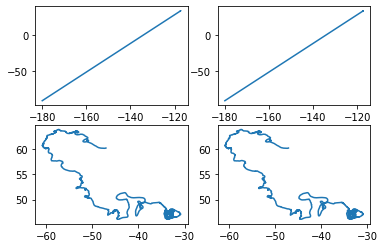

In [44]:
# Retrospectively fix the lon/lat problem
ax1 = plt.subplot(2,2,1)
plt.plot(ds_raw[lonname], ds_raw[latname])
ax2 = plt.subplot(2,2,2)
plt.plot(ds_qc[lonname], ds_qc[latname])
#ax2.title('QC')
ax3 = plt.subplot(2,2,3)
plt.plot(ds_lowess[lonname], ds_lowess[latname])
ax4 = plt.subplot(2,2,4)
plt.plot(ds_hourly[lonname], ds_hourly[latname])



In [92]:
# Create a table summarising the data?
all_tstart= np.zeros(len(PID), dtype='datetime64[ns]')

#all_tend = np.ones(len(PID), dtype=datetime64[ns])

for i in range(len(PID)):
    # Get a single platform ID from the full list
    pid1 = (PID["PID"].values)[i].astype('str')
    PID1 = (PID["PID"].values)[i]


    fname = 'pid'+str(PID1)+'_*'
    hourly_files = glob.glob(cat_interim_path(fname))
    if len(hourly_files):
        hourly_files = sorted(hourly_files)
        # Find the most recent file (alphabetically, rather than by time)
        hourly_files = hourly_files[-1]

        ds_hourly = xr.open_dataset(hourly_files)

        total = ds_hourly.attrs["total_points_orig"]
        total_qc = ds_hourly.attrs["qc_points"]
        tstart = ds_hourly.time.min().values
        tend = ds_hourly.time.max().values
        
        all_tstart[i] = tstart
#        all_tend.append(tend)
    else:
        all_tstart[i] = np.datetime64("NaT")



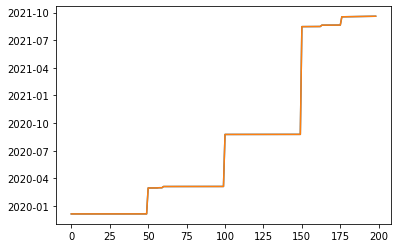

In [98]:
plt.plot(np.sort(all_tstart))
isort = np.argsort(all_tstart)

plt.plot(all_tstart[isort])

(array([50.,  0.,  0.,  0.,  0.,  0., 50.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0., 50.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 26.,  0., 23.]),
 array([18234.875     , 18247.95416667, 18261.03333333, 18274.1125    ,
        18287.19166667, 18300.27083333, 18313.35      , 18326.42916667,
        18339.50833333, 18352.5875    , 18365.66666667, 18378.74583333,
        18391.825     , 18404.90416667, 18417.98333333, 18431.0625    ,
        18444.14166667, 18457.22083333, 18470.3       , 18483.37916667,
        18496.45833333, 18509.5375    , 18522.61666667, 18535.69583333,
        18548.775     , 18561.85416667, 18574.93333333, 18588.0125    ,
        18601.09166667, 18614.17083333, 18627.25      , 18640.32916667,
        18653.40833333, 18666.4875    , 18679.56666667, 18692.64583333,
        18705.725     , 18718.80416667, 18731.88333333, 18744.9625  

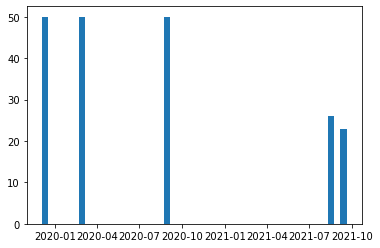

In [102]:
plt.hist(all_tstart, 50)

In [ ]:
iif 0:

    # ~ ~ print update ~ ~ 
    if len(existing_files) > 0:
        print("Existing raw data files: \n%s\n" % existing_files)
    else:
        sys.exit("No previous raw data files.\n")

    # ~ ~ filenaming convention ~ ~
    # If there are multiple files with raw data (i.e. non-updated datasets), select 
    # the latest one updated.
    # The file names are distinguished by the timestamp appended to the filename 
    # and has <tstamp_strftime> format (see 'user edits' section).
    # The data are cropped such that the last day is fully sampled (spans 0h-23h).
    # The timestamp in the filename is the latest downloaded fully sampled day.

    # Extract the timestamp part of the filename(s) in a list
    tstamp = [date for file in existing_files 
                for date in re.findall("(\d{8})", file)]

    # Convert to datetime and pick the most recent timestamp
    tstamp_date = pd.to_datetime(tstamp, format=tstamp_strftime)
    fname_timestamp = tstamp[tstamp_date.argmax()]

    # Load the raw file with the latest timestamp
    ds_fname = f"{fnames.fname_rawdata}{fname_timestamp}.nc"
    ds_fpath = os.path.join(data_dir, ds_fname)

    print("Opening file: %s\n" % ds_fpath)
    ds_raw = xr.open_dataset(ds_fpath)
